In [1]:
import pandas as pd
from pgmpy.models import BayesianModel
from tqdm import tqdm
import numpy as np
from pgmpy.inference import VariableElimination
import random
import networkx as nx
import pylab as plt
from sklearn.cluster import AgglomerativeClustering
from collections import Counter
from create_network import create_network
from logloss import logloss
from pgmpy.estimators import HillClimbSearch, BayesianEstimator, MaximumLikelihoodEstimator, BicScore

In [2]:
train_features = pd.read_csv('test_features.csv')
train_targets = pd.read_csv('train_targets_scored.csv')

In [3]:
df = pd.read_csv('train_features_binary.csv')
df.drop('Unnamed: 0',inplace=True,axis=1)

In [4]:
dose_decode = []
for i,dose in enumerate(list(df['cp_dose'])):
    if dose == 'D1':
        dose_decode.append(0)
    if dose == 'D2':
        dose_decode.append(1)
df['cp_dose'] = dose_decode

In [5]:
#random train_test_split
train_df = df.sample(int(len(df)*.85))
test_df = df.drop(list(train_df.index),axis=0)
train_df.reset_index(inplace=True,drop=True)
test_df.reset_index(inplace=True,drop=True)

In [6]:
samp_sub = pd.read_csv('sample_submission.csv')

In [7]:
n_clusters = 70

In [8]:
train_df

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99,target
0,id_32bb9dd91,trt_cp,72,1,0,0,0,1,0,1,...,1,0,1,0,0,0,0,0,0,raf_inhibitor
1,id_a89cd3ca0,trt_cp,24,0,1,0,0,1,1,1,...,1,0,1,1,1,1,0,1,1,acetylcholine_receptor_agonist
2,id_ac1dceedd,trt_cp,72,1,1,1,1,0,0,0,...,0,1,0,1,1,0,0,0,1,pdgfr_inhibitor
3,id_debc8fb6b,trt_cp,24,1,1,1,1,0,0,1,...,1,0,1,1,1,1,1,0,1,calcium_channel_blocker
4,id_2e49855ca,trt_cp,48,1,1,0,0,0,1,0,...,0,1,0,1,1,1,1,0,0,fgfr_inhibitor
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14312,id_6e08033f6,trt_cp,72,0,1,1,0,1,0,0,...,1,1,0,1,1,0,0,1,1,lipoxygenase_inhibitor
14313,id_29b15ed4c,trt_cp,72,1,1,1,0,1,0,0,...,0,1,1,1,1,1,1,1,1,jak_inhibitor
14314,id_b80ce1333,trt_cp,72,0,1,0,1,1,1,0,...,0,1,1,1,1,1,1,1,1,bacterial_dna_gyrase_inhibitor
14315,id_f71654ed5,trt_cp,72,0,1,1,1,0,0,0,...,1,0,0,0,1,0,1,1,0,sodium_channel_inhibitor


In [9]:
clust_model = AgglomerativeClustering(n_clusters=n_clusters, affinity='euclidean', linkage='ward')
clust_model.fit(train_df[train_df.columns[4:-1]].transpose())

AgglomerativeClustering(n_clusters=70)

In [10]:
cluster_labels = dict(zip(train_features.columns[4:],clust_model.labels_))

In [11]:
clusters = {}
for i in range(n_clusters):
    clusters[i] = []
for feature in cluster_labels.keys():
    clusters[cluster_labels[feature]].append(feature)

In [12]:
for key in clusters.keys():
    clusters[key].append('cp_dose')
    random.shuffle(clusters[key])
    clusters[key].append('target')

In [13]:
clusters

{0: ['g-270',
  'g-751',
  'g-517',
  'g-255',
  'g-711',
  'g-389',
  'g-355',
  'g-666',
  'g-558',
  'g-591',
  'g-53',
  'g-656',
  'cp_dose',
  'g-162',
  'g-698',
  'g-164',
  'g-300',
  'g-233',
  'target'],
 1: ['g-358',
  'g-107',
  'cp_dose',
  'g-211',
  'g-465',
  'g-542',
  'g-545',
  'g-384',
  'g-291',
  'g-510',
  'g-150',
  'g-395',
  'g-56',
  'g-674',
  'g-179',
  'g-401',
  'g-678',
  'g-110',
  'target'],
 2: ['g-189',
  'g-203',
  'cp_dose',
  'g-509',
  'g-667',
  'g-682',
  'g-26',
  'g-186',
  'g-160',
  'g-562',
  'g-138',
  'g-714',
  'g-571',
  'g-670',
  'g-342',
  'g-508',
  'g-75',
  'g-565',
  'g-364',
  'g-479',
  'g-9',
  'g-16',
  'g-391',
  'g-276',
  'g-561',
  'g-113',
  'target'],
 3: ['g-705',
  'g-50',
  'g-29',
  'cp_dose',
  'g-511',
  'g-20',
  'g-294',
  'g-459',
  'g-653',
  'g-498',
  'g-287',
  'g-223',
  'g-371',
  'g-434',
  'g-638',
  'target'],
 4: ['g-754',
  'g-363',
  'g-570',
  'g-408',
  'g-366',
  'g-340',
  'g-633',
  'g-76',
 

fitting model 0...


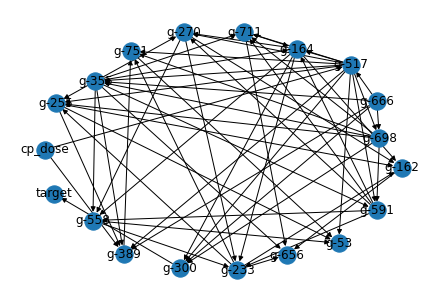

 51%|██████████████████████████████████████                                     | 1283/2527 [00:00<00:00, 12818.40it/s]

making evidence...


  0%|                                                                                         | 0/2527 [00:00<?, ?it/s]C:\Users\leesc\miniconda3\envs\tensorflownew\lib\site-packages\ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  0%|                                                                                 | 1/2527 [00:00<05:51,  7.19it/s]

predicting...


C:\Users\leesc\miniconda3\envs\tensorflownew\lib\site-packages\ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  4%|██▊                                                                            | 91/2527 [00:00<00:05, 448.06it/s]

scoring and logging...


100%|█████████████████████████████████████████████████████████████████████████████| 2527/2527 [00:05<00:00, 456.48it/s]


Cluster 0 score: 0.03803613599098181
fitting model 1...


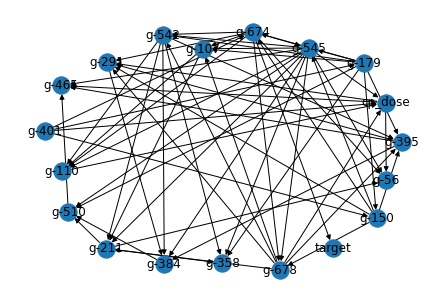

100%|███████████████████████████████████████████████████████████████████████████| 2527/2527 [00:00<00:00, 12751.05it/s]

making evidence...



  0%|                                                                                         | 0/2527 [00:00<?, ?it/s]C:\Users\leesc\miniconda3\envs\tensorflownew\lib\site-packages\ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  0%|                                                                                 | 1/2527 [00:00<05:59,  7.04it/s]

predicting...


C:\Users\leesc\miniconda3\envs\tensorflownew\lib\site-packages\ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  2%|█▍                                                                             | 46/2527 [00:00<00:05, 455.04it/s]

scoring and logging...


100%|█████████████████████████████████████████████████████████████████████████████| 2527/2527 [00:05<00:00, 459.37it/s]


Cluster 1 score: 0.03815220446306059
fitting model 2...


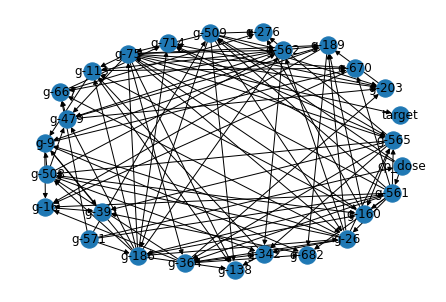

 70%|█████████████████████████████████████████████████████▎                      | 1771/2527 [00:00<00:00, 8828.79it/s]

making evidence...


  0%|                                                                                         | 0/2527 [00:00<?, ?it/s]

predicting...


C:\Users\leesc\miniconda3\envs\tensorflownew\lib\site-packages\ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  0%|                                                                                 | 1/2527 [00:00<11:52,  3.54it/s]C:\Users\leesc\miniconda3\envs\tensorflownew\lib\site-packages\ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  2%|█▍                                                                             | 45/2527 [00:00<00:05, 449.59it/s]

scoring and logging...


100%|█████████████████████████████████████████████████████████████████████████████| 2527/2527 [00:05<00:00, 452.62it/s]


Cluster 2 score: 0.03910116082108691
fitting model 3...


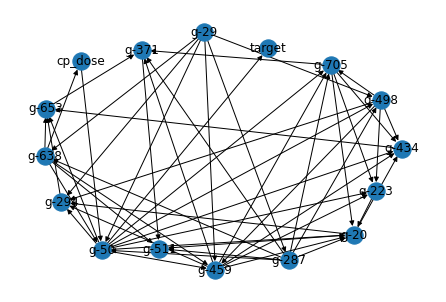

100%|███████████████████████████████████████████████████████████████████████████| 2527/2527 [00:00<00:00, 15584.64it/s]

making evidence...



  0%|                                                                                         | 0/2527 [00:00<?, ?it/s]C:\Users\leesc\miniconda3\envs\tensorflownew\lib\site-packages\ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  0%|                                                                                 | 1/2527 [00:00<05:51,  7.19it/s]

predicting...


C:\Users\leesc\miniconda3\envs\tensorflownew\lib\site-packages\ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  4%|██▉                                                                            | 92/2527 [00:00<00:05, 456.39it/s]

scoring and logging...


100%|█████████████████████████████████████████████████████████████████████████████| 2527/2527 [00:05<00:00, 447.20it/s]


Cluster 3 score: 0.03823161855998066
fitting model 4...


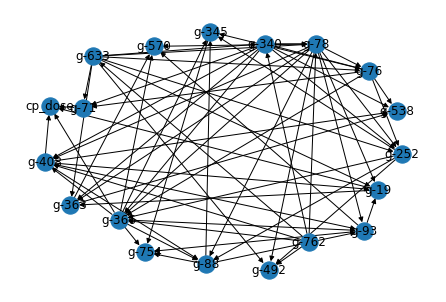

 97%|████████████████████████████████████████████████████████████████████████▉  | 2456/2527 [00:00<00:00, 12177.63it/s]

making evidence...


  0%|                                                                                         | 0/2527 [00:00<?, ?it/s]


predicting...
fitting model 5...


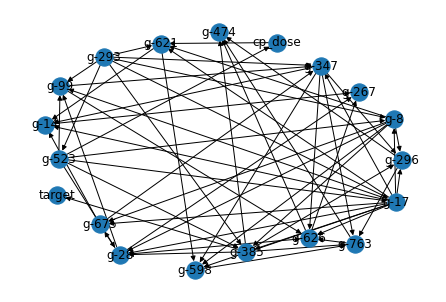

100%|███████████████████████████████████████████████████████████████████████████| 2527/2527 [00:00<00:00, 12815.73it/s]

making evidence...



  0%|                                                                                         | 0/2527 [00:00<?, ?it/s]C:\Users\leesc\miniconda3\envs\tensorflownew\lib\site-packages\ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  0%|                                                                                 | 1/2527 [00:00<05:43,  7.35it/s]

predicting...


C:\Users\leesc\miniconda3\envs\tensorflownew\lib\site-packages\ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 73%|████████████████████████████████████████████████████████▉                     | 1845/2527 [04:03<01:29,  7.61it/s]

In [ ]:
scores_summ = {}
submissions = {}
for clust in list(clusters.keys()):
    try:
        print(f'fitting model {clust}...')
        bic=BicScore(train_df[clusters[clust]])
        hc=HillClimbSearch(train_df[clusters[clust]], scoring_method=bic)
        best_model=hc.estimate()
        edges=best_model.edges()
        model=BayesianModel(edges)
        model.fit(train_df,estimator=BayesianEstimator, prior_type="BDeu")

        nx.draw(model, with_labels=True)
        plt.show()

        print('making evidence...')
        evidence = {}
        for i in tqdm(range(len(test_df))):
            evidence[i] = {}
            for node in clusters[clust][:-1]:
                evidence[i][node] = test_df[node][i]

        infer = VariableElimination(model)

        samp_sub = pd.read_csv('sample_submission.csv')
        samp_sub = samp_sub[:len(test_df)]
        
        print('predicting...')
        for i in tqdm(range(len(test_df))):
            q = infer.query(variables=['target'],evidence=evidence[i],show_progress=False)
            #print(q)
            preds = dict(zip(list(q.state_names['target']),list(q.values)))
            for key in preds.keys():
                samp_sub[key][i] = preds[key]
                samp_sub['sig_id'][i] = test_df['sig_id'][i]
        
        submissions[clust] = samp_sub
        
        print('scoring and logging...')
        scores = []
        for i in tqdm(range(len(samp_sub))):
            pred = list(np.array(samp_sub.iloc[i][1:]))
            act = list(np.array(train_targets[train_targets['sig_id'] == samp_sub['sig_id'].iloc[0]].drop('sig_id',axis=1))[0])
            scores.append(logloss(act,pred))

        scores_summ[clust] = dict(zip(list(train_targets['sig_id']),scores))
       
        overall_logloss = np.mean(scores)

        network = []
        for node in clusters[clust]:
            if len(model.get_children(node)) != 0:
                for child in model.get_children(node):
                    network.append((node,child))

        logs = pd.read_csv('logs.csv',index_col=False)
        logs = logs.append({'Network' : network , 'Nodes Count': len(clusters[clust]),'Edges Count': len(network),'Score' : overall_logloss} , ignore_index=True)
        logs.to_csv('logs.csv',index=False)

        print(f'Cluster {clust} score: {overall_logloss}')
        
    except:
        pass

In [ ]:
overall_logloss

In [ ]:
scores_summ[7].values()

In [ ]:
scores_summ[6].values()

In [ ]:
samp_sub_2

In [ ]:
len(test_df)

In [ ]:
samp_sub[:2528]